# Time series clustering based on autocorrelation

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from statsmodels.tsa.arima_process import ArmaProcess

/Users/willie/.local/share/virtualenvs/time-series-demos-svg3QhUy/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 1 Generate time series dataset

In [2]:
# Define the ARMA processes. AR params must be negated. See
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html
processes = [
    ArmaProcess.from_coeffs([0.0], [0.0]),
    ArmaProcess.from_coeffs([-0.5], [0.0]),
    ArmaProcess.from_coeffs([0.0], [0.9])
]

In [3]:
# Generate the time series.
df = pd.DataFrame()
for i in range(12):
    df[f"TS_{i}"] = processes[i // 4].generate_sample(500)

In [4]:
df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,0.814901,-0.857932,-0.295329,-0.629645,1.725390,0.204556,0.829519,0.122906,-0.257948,1.205731,-0.177147,1.130207
1,1.799261,-0.905892,0.850145,0.488714,-3.297273,-1.220666,-0.443759,-2.491313,0.656567,0.936846,0.515166,0.237403
2,-3.038602,-0.904267,-0.433562,-1.234180,1.513335,1.772213,-0.944069,0.185462,0.318072,-0.464748,1.886760,1.195891
3,0.559198,-0.173408,1.890429,0.160278,-2.825817,-1.652029,0.376112,0.806867,-1.285331,-1.713372,0.963212,0.669327
4,-1.552699,0.173476,-0.509968,-1.503897,0.846738,1.209292,-0.051814,0.832931,-0.746232,-1.256615,1.474515,-0.764653
5,-1.412035,0.375487,1.302733,-0.572692,-0.730722,0.616719,0.228942,-0.394136,-1.183716,-1.727387,1.503295,-0.753360
6,-0.002678,0.501175,0.000272,-1.989080,0.814146,0.400676,-0.529105,-0.363031,-1.983308,-1.381367,0.080035,-0.646984
7,0.601512,-2.297091,-1.248318,0.790205,-0.960265,-0.729521,-0.002020,1.651087,-0.823964,0.021662,2.141579,0.052297
8,-0.415589,0.146217,1.188254,0.587159,0.916830,-0.081323,0.112155,-1.082070,-0.006372,-0.131613,0.831576,0.955281
9,-1.041914,-1.665160,1.227353,-0.077787,0.765775,-1.078060,0.615463,0.434055,0.955669,-1.886881,-1.729917,-0.626688


In [5]:
def plot_df(df, lower, upper):
    title = f"TS {lower}-{upper}"
    df.iloc[:, lower:upper].plot(title=title, figsize=(12, 4), alpha=0.4)
    plt.show()

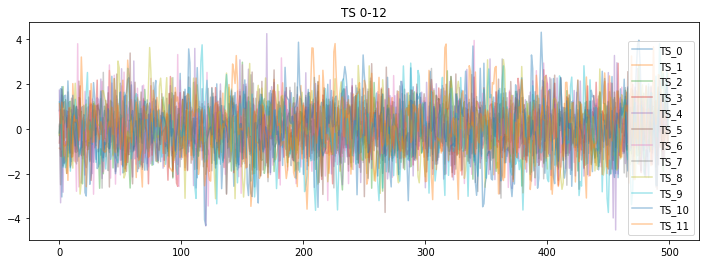

In [6]:
plot_df(df, 0, 12)

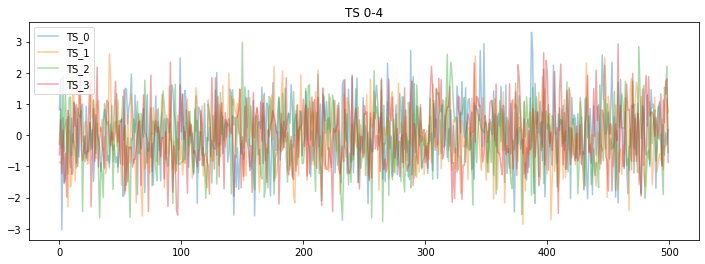

In [7]:
plot_df(df, 0, 4)

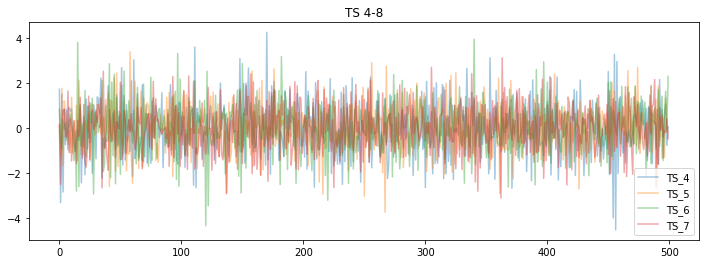

In [8]:
plot_df(df, 4, 8)

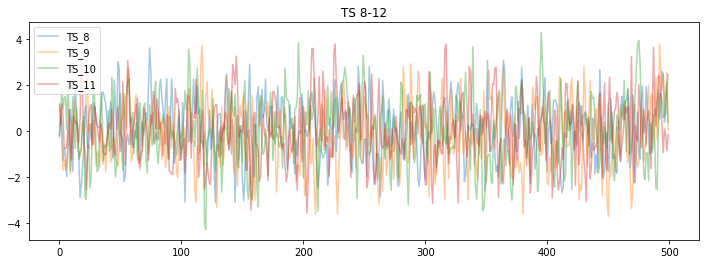

In [9]:
plot_df(df, 8, 12)

## 2 Estimate ACFs 

In [10]:
max_lag = 10
lag_arr = np.repeat(max_lag, df.shape[1])
acf_list = list(map(sm.tsa.acf, df.transpose().to_numpy(), lag_arr))
acf_df = pd.DataFrame(acf_list).transpose()
acf_df.columns = df.columns

In [11]:
acf_df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,-0.042163,0.079918,-0.006299,0.043987,-0.542348,-0.441039,-0.515097,-0.466030,0.466626,0.473216,0.525871,0.487848
2,-0.003809,-0.090066,0.049970,0.027018,0.322887,0.138230,0.232681,0.214090,-0.003507,0.036382,0.032027,-0.044020
3,0.049377,-0.028255,0.078828,-0.027806,-0.184419,-0.079734,-0.081405,-0.161625,0.049277,0.152894,0.014549,-0.048767
4,0.071278,0.076481,-0.035201,-0.034383,0.059653,0.118018,0.072427,0.128648,-0.004479,0.124923,0.041731,-0.011513
5,0.004266,0.015168,-0.004421,-0.032709,-0.031306,-0.087933,-0.067031,-0.052322,-0.036262,0.044977,0.060330,0.041849
6,-0.059764,0.030706,0.023132,0.028391,0.007695,0.097892,0.058917,-0.012626,-0.025086,0.031009,0.038804,0.048658
7,0.030157,-0.051301,-0.067635,0.069318,0.004008,-0.101109,-0.062918,0.036700,-0.036394,0.046182,0.024285,-0.016949
8,-0.012567,-0.065762,-0.008667,0.071380,0.026192,0.078286,0.067145,-0.041635,0.021978,0.011306,0.035439,-0.009676
9,-0.002424,-0.028715,0.009242,0.070695,-0.039439,-0.082665,-0.054574,0.047262,0.086086,-0.050723,0.003351,-0.015622


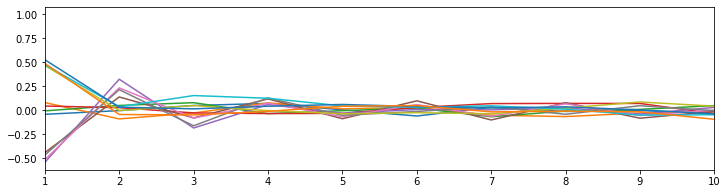

In [12]:
plt.figure(figsize=(12, 3))
plt.xlim((1, max_lag))
plt.plot(acf_df)
plt.show()

## 3 Find clusters

In [13]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(acf_df.transpose())
kmeans.labels_

array([2, 2, 2, 2, 0, 0, 0, 0, 1, 1, 1, 1], dtype=int32)

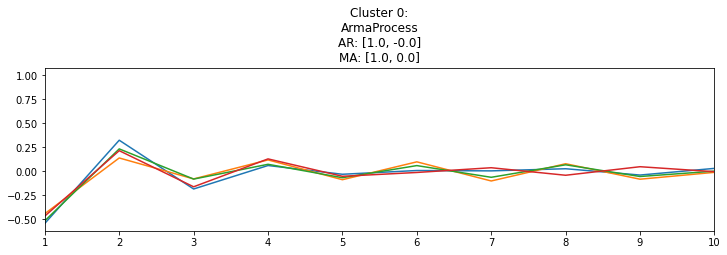

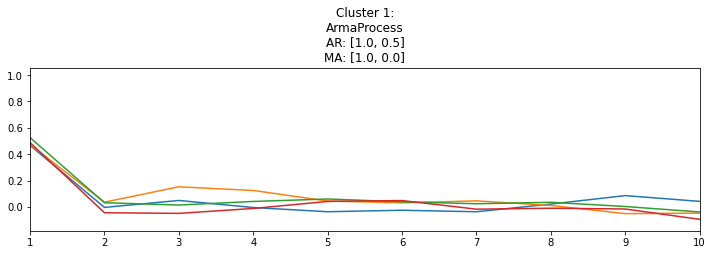

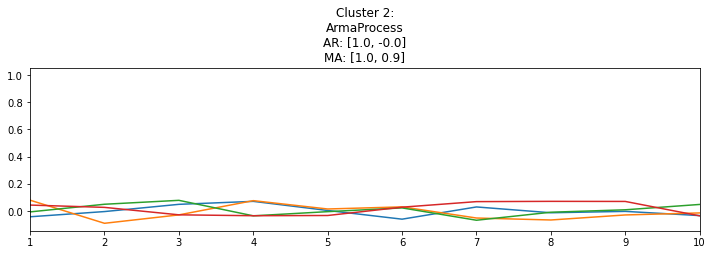

In [14]:
for i in range(3):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, max_lag))
    for j in range(acf_df.shape[1]):
        if kmeans.labels_[j] == i:
            plt.title(f"Cluster {i}:\n{processes[i]}")
            plt.plot(acf_df.iloc[:, j])
    plt.show()